In [2]:
import shutil
import os


# KÜTÜPHANELER

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob as gb
import os
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

# DATASET YÜKLEME

In [8]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dir_name.split()[-1]!='GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [9]:
all_path=[] #  her resmin tam yolunu içerecek
for img_path in os.listdir(fish_dir):
    if img_path in ['Segmentation_example_script.m','README.txt','license.txt'] :
        continue

    all_data=gb.glob(pathname=fish_dir+'/'+img_path+'/'+img_path+'/*.*')
    all_path.extend(all_data)# Bulunan tüm dosya yollarını all_path listesine ekler.

In [10]:
df=pd.DataFrame({'Filepath':all_path})
df['Label']=df['Filepath'].apply(lambda x :x.split('/')[-2])
pd.options.display.max_colwidth = 200

#df satırlarını karıştırır ve indexleri sıfırlar(yeniden oluşturur)
df = df.sample(frac=1).reset_index(drop = True)
df.head(5)

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00768.png,Black Sea Sprat
1,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00635.png,Shrimp
2,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00407.png,Shrimp
3,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00121.png,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00953.png,Shrimp


 #  ***EDA(Exploratory Data Analysis)***

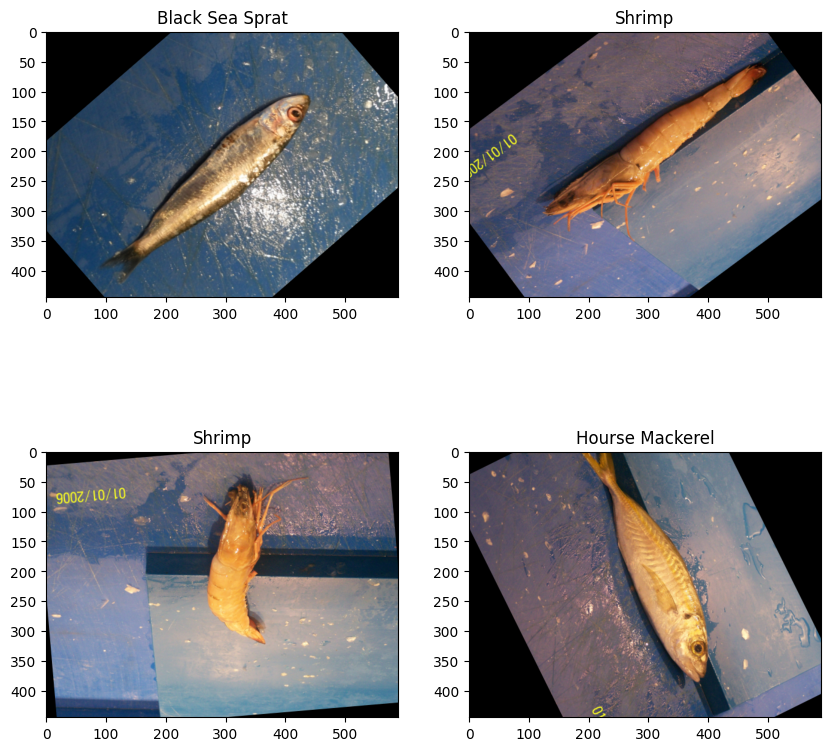

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) # 2 satır 2 sütun ve her görsel 10x10 pixel boyutunda

#axs.flatten() ile 2x2'lik matristen (alt grafiklerden) düz bir liste yapıyor, böylece her grafik için bir döngü oluşturuluyor.
#enumerate ile her grafiğin indexini tutuyoruz. Düz listeyi sırayla gezerken her bir alt grafiği (ax) ve indeksini (i) döner.
for i, ax in enumerate(axs.flatten()):
    img = Image.open(df['Filepath'].iloc[i])
    ax.imshow(img)
    ax.set_title(df['Label'].iloc[i])
plt.show()  # Rastgele görüntüleri görselleştirme

In [12]:
df.isnull().sum() #Etiketlenmemiş bir görsel ya da path değeri olmayan bir veri var mı diye kontrol

Filepath    0
Label       0
dtype: int64

In [13]:
df.describe()  # Verinin genel istatistiksel özetini çıkarma
#top: En sık karşılaşılan (mod) değeri gösteriyor.
#freq: En sık karşılaşılan değerin kaç kere tekrarlandığını gösteriyor.

,Filepath,Label
count,9000,9000
unique,9000,9
top,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00768.png,Black Sea Sprat
freq,1,1000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  9000 non-null   object
 1   Label     9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [15]:
# Balık türleri
unique_values = df['Label'].unique()
unique_values

array(['Black Sea Sprat', 'Shrimp', 'Hourse Mackerel', 'Gilt-Head Bream',
       'Red Sea Bream', 'Red Mullet', 'Sea Bass', 'Striped Red Mullet',
       'Trout'], dtype=object)

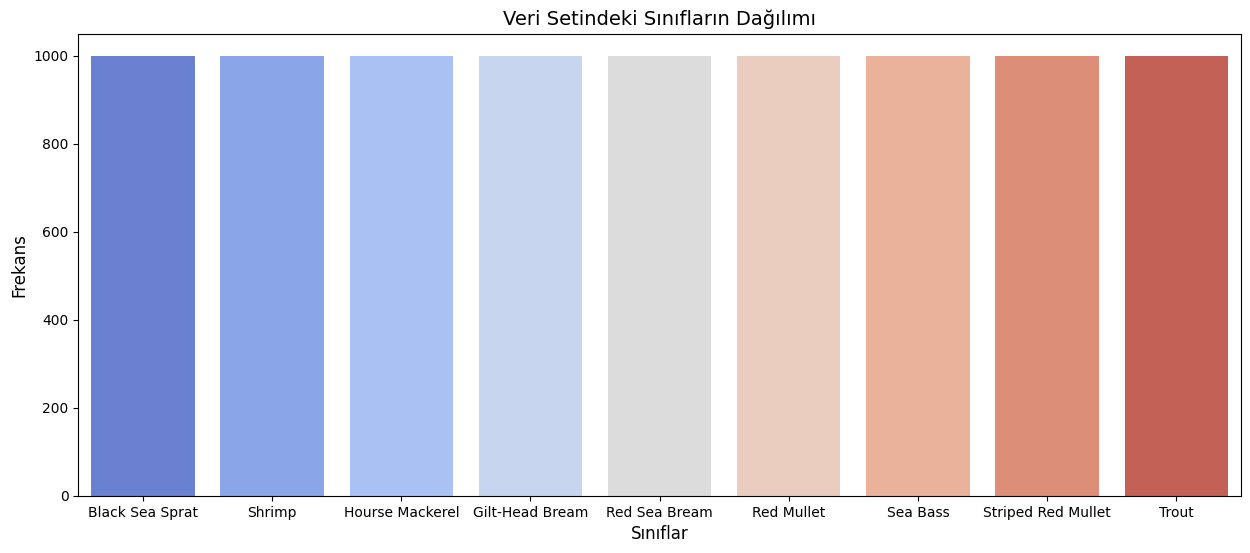

In [16]:
# Tüm veri setindeki sınıf dağılımını görüntüleyelim.
plt.figure(figsize=(15, 6))

sns.countplot(x=df['Label'], palette='coolwarm')

plt.title('Veri Setindeki Sınıfların Dağılımı', fontsize=14)
plt.xlabel('Sınıflar', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.show()


EĞİTİM HAZIRLIĞI

In [17]:
# Veriyi eğitim ve test kümelerine ayırma
train_df, test_df = train_test_split(df, train_size=0.9, shuffle=True, random_state=1)

shuffle, veriyi rastgele karıştırmak için kullanılan bir parametredir. Genellikle veri setini model eğitimi sırasında karıştırmak (shuffle etmek) iyi bir uygulamadır, çünkü bu sayede model veriyi daha çeşitli bir sırayla görür ve daha iyi genelleştirme yapabilir. Eğer veri karıştırılmazsa, model sıralı verilere göre öğrenebilir, bu da modelin overfitting (aşırı öğrenme) yapmasına neden olabilir.

shuffle Parametresi Nerede Kullanılır?
1. train_test_split() Fonksiyonunda: train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True)
2. Veri Üretici (Generator) Kullanımında:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True
)

Ne Zaman shuffle=True Kullanılmalı?
Eğitim Setinde: Eğitim verilerini karıştırmak genellikle iyi bir uygulamadır. Bu, modelin her eğitim iterasyonunda (epoch) farklı veri sıralarını görmesini ve daha iyi bir genelleme yapmasını sağlar.
Doğrulama ve Test Setlerinde: Genellikle shuffle=False olarak bırakılır. Çünkü doğrulama ve test sırasında belirli bir veri sıralamasında değerlendirme yapılması istenir.
Özetle, shuffle veriyi karıştırarak modelin daha dengeli ve çeşitli veri örnekleri görmesini sağlayan önemli bir parametredir.

In [18]:
train_df.head() # eğitim setindeki ilk 5 veri

,Filepath,Label
7631,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00628.png,Sea Bass
3543,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00249.png,Sea Bass
7585,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00065.png,Black Sea Sprat
7510,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00217.png,Black Sea Sprat
7591,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00874.png,Red Mullet


In [19]:
train_df.shape #eğitim seti boyutu

(8100, 2)

In [20]:
test_df.head() # test setindeki ilk 5 veri

,Filepath,Label
5221,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/00384.png,Trout
2975,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00830.png,Sea Bass
5786,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00713.png,Sea Bass
8591,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00280.png,Red Sea Bream
1321,/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00912.png,Sea Bass


In [21]:
test_df.shape # test seti boyutu

(900, 2)

***Veri Arttırma*** :
Veri arttırma (data augmentation), eğitim setine her seferinde rastgele değişiklikler uygulayarak modelin daha genel sonuçlar verebilmesi için veri çeşitliliği sağlar. Veri arttırma, eğitim sırasında her bir batch için farklı veriler üretir, ancak toplam veri sayısını doğrudan artırmaz. Yani, model her epoch'ta farklı varyasyonları görse de orijinal veri setinin boyutu aynı kalır.

# VERİ ARTTIRMA

In [22]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma işlemleri: döndürme, kaydırma, yakınlaştırma ve çevirme gibi işlemler ekleniyor (ImageDataGenerator)
train_generator = ImageDataGenerator(
    rescale=1./255,           # Tüm görüntüleri 0-1 arasında normalize et
    rotation_range=30,        # Rastgele 30 dereceye kadar döndürme
    width_shift_range=0.2,    # Genişlik ekseninde %20 kaydırma
    height_shift_range=0.2,   # Yükseklik ekseninde %20 kaydırma
    shear_range=0.2,          # Şeritleme işlemi
    zoom_range=0.3,           # Rastgele yakınlaştırma
    horizontal_flip=True,     # Yatay yansıtma
    fill_mode='nearest',      # Kaydırma veya döndürme sonrası boş kalan pikselleri en yakın değerle doldur
    validation_split=0.2      # Eğitim ve doğrulama verilerini ayırmak için %20 doğrulama
)

# Doğrulama verileri için sadece normalizasyon uygulanıyor (veri artırma yapılmıyor)
valid_generator = ImageDataGenerator(
    rescale=1./255,           # Sadece normalizasyon
    validation_split=0.2      # Eğitim ve doğrulama verilerini ayırmak için %20 doğrulama
)

# Test verileri için sadece normalizasyon uygulanıyor
test_generator = ImageDataGenerator(
    rescale=1./255            # Sadece normalizasyon
)

In [23]:
train_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory='all_data',  # Görüntülerin bulunduğu klasör
    x_col='Filepath',  # DataFrame'de dosya yollarını içeren sütun
    y_col='Label',  # DataFrame'de sınıf etiketlerini içeren sütun
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Veri kümesi %20'lik bir doğrulama setine ayrılıyor (subset='training' ifadesiyle, kalan %80 eğitim için kullanılıyor).
)

validation_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    directory='all_data',  # Görüntülerin bulunduğu klasör
    x_col='Filepath',  # DataFrame'de dosya yollarını içeren sütun
    y_col='Label',  # DataFrame'de sınıf etiketlerini içeren sütun
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Doğrulama verileri için
)

test_data = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory='all_data',  # Görüntülerin bulunduğu klasör
    x_col='Filepath',  # DataFrame'de dosya yollarını içeren sütun
    y_col='Label',  # DataFrame'de sınıf etiketlerini içeren sütun
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
    #shuffle parametresi, özellikle eğitim verileriyle çalışırken önemli bir rol oynar. Eğer shuffle=True olarak ayarlanırsa, her epoch başlangıcında
    #veri rastgele bir şekilde karıştırılır. Bu, modelin her eğitim adımında verilerden daha iyi genelleme yapmasını sağlar ve modelin aşırı öğrenmesini
    #(overfitting) engellemeye yardımcı olur.
)


Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


# MODEL OLUŞTURMA

In [24]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Rescaling, Flatten
from tensorflow.keras.models import Sequential

# Modelin tanımlanması
model = Sequential([

    # Görüntülerin normalleştirilmesi
    Rescaling(1./255, input_shape=(224, 224, 3)),

    Flatten(),

    # Dense katmanları
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(9, activation="softmax")
])


In [25]:
model.summary() #sinir ağının özet modeli

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,301,897 (73.63 MB)

 Trainable params: 19,301,897 (73.63 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Daha küçük öğrenme oranı

# Modeli derle
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# MODEL EĞİTİMİ

Eğer modelinizin genel olarak iyi bir tahmin yapmasını ve aşırı öğrenmeden kaçınmasını istiyorsanız, val_loss izlemek mantıklı bir seçenek olacaktır.
Eğer modelinizin performansını doğruluğa göre değerlendirmek istiyorsanız ve modelin en yüksek doğruluğa ulaşmasını istiyorsanız, val_accuracy izlemek daha uygun olabilir.

Genel performans ve aşırı öğrenmeyi önleme: val_loss
Doğruluk odaklı sınıflandırma: val_accuracy

In [27]:

# Erken durdurma ayarı (patience=5, eğer 5 epoch boyunca iyileşme olmazsa durur)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # patience arttırıldı

# Öğrenme oranını dinamik oluşturuyoruz
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
          return float(lr * tf.math.exp(-0.1))

# LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Model eğitimi
history = model.fit(
    train_data,  # Eğitim veri kümesi
    validation_data=validation_data,  # Doğrulama veri kümesi
    epochs=10,  # Maksimum epoch sayısı
    callbacks=[lr_scheduler,early_stop]
)


Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.1264 - loss: 2.1979 - val_accuracy: 0.2253 - val_loss: 2.0521 - learning_rate: 0.0010
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.2205 - loss: 2.0223 - val_accuracy: 0.2802 - val_loss: 1.9027 - learning_rate: 0.0010
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.2546 - loss: 1.9245 - val_accuracy: 0.3204 - val_loss: 1.8579 - learning_rate: 0.0010
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.2783 - loss: 1.8879 - val_accuracy: 0.3216 - val_loss: 1.7976 - learning_rate: 0.0010
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.2863 - loss: 1.8534 - val_accuracy: 0.3253 - val_loss: 1.8014 - learning_rate: 0.0010
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.3059 - loss: 1.8285 - val_accuracy: 0.3216 - val_loss: 1.7931 - learning_rate: 9.0484e-04
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.3016 - loss

# MODEL SONUÇLARI

In [28]:
# Test verisi üzerinde modelin performansını değerlendirme
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy}')


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 553ms/step - accuracy: 0.4886 - loss: 1.5209
Test Accuracy: 0.4555555582046509


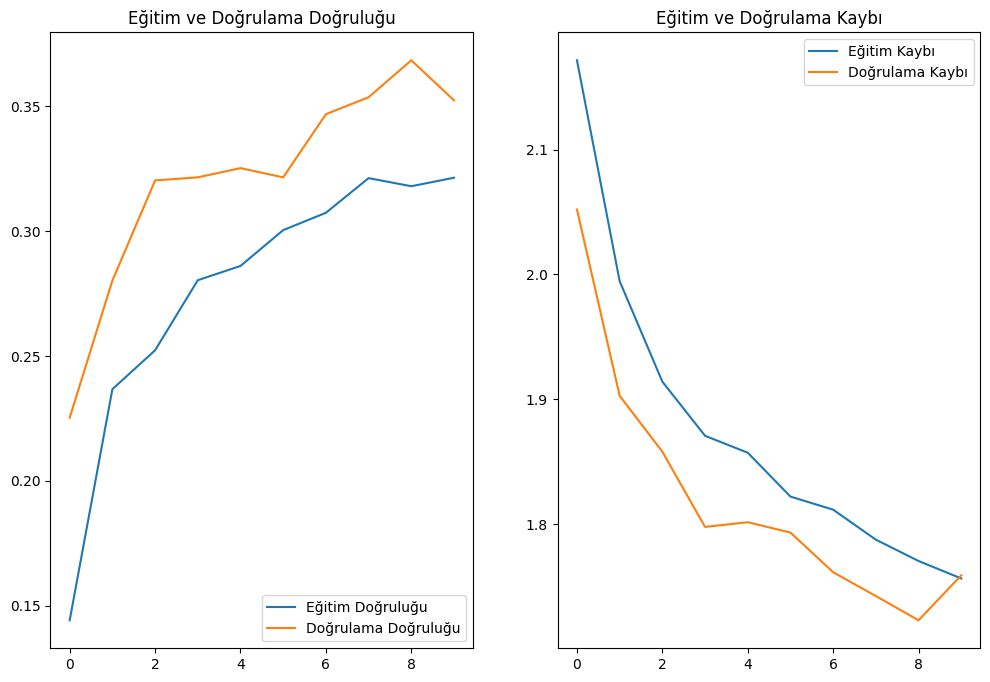

In [29]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıp ve doğruluk değerlerini elde etme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Kayıp ve doğruluk grafikleri
plt.figure(figsize=(12, 8))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right') # açıklamanın grafikteki konumu (sağ üst)
plt.title('Eğitim ve Doğrulama Doğruluğu')

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right') # açıklamanın grafikteki konumu (sağ üst)
plt.title('Eğitim ve Doğrulama Kaybı')

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step


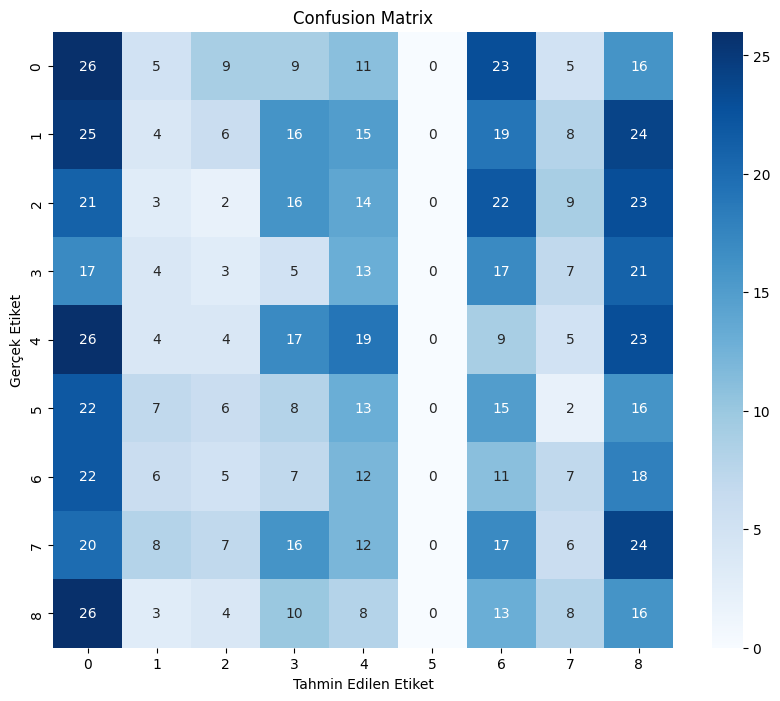

Classification Report
                    precision    recall  f1-score   support

   Black Sea Sprat       0.13      0.25      0.17       104
   Gilt-Head Bream       0.09      0.03      0.05       117
   Hourse Mackerel       0.04      0.02      0.03       110
        Red Mullet       0.05      0.06      0.05        87
     Red Sea Bream       0.16      0.18      0.17       107
          Sea Bass       0.00      0.00      0.00        89
            Shrimp       0.08      0.12      0.09        88
Striped Red Mullet       0.11      0.05      0.07       110
             Trout       0.09      0.18      0.12        88

          accuracy                           0.10       900
         macro avg       0.08      0.10      0.08       900
      weighted avg       0.08      0.10      0.08       900



In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Test verilerinde tahminler yapma
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Gerçek etiketler
y_true = test_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix grafiği
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Classification Report
target_names = list(test_data.class_indices.keys())
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))


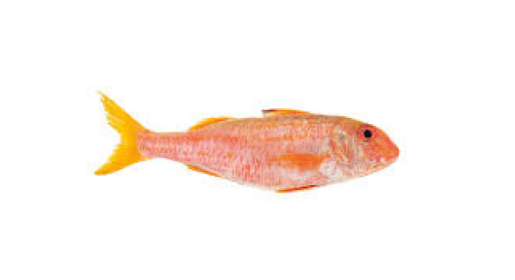

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tahmin Edilen Sınıf: Shrimp


In [35]:
from tensorflow.keras.utils import load_img, img_to_array  # Gerekli fonksiyonları içe aktar
from PIL import Image  # PIL kütüphanesini içe aktar
import matplotlib.pyplot as plt

# Görseli yükleme ve yeniden boyutlandırma
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Görüntüyü yükleme
    img = load_img(img_path, target_size=target_size)  
    img_array = img_to_array(img)  # Görüntüyü numpy array'e çevirme
    img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği format
    img_array /= 255.0  # Modelin eğitimine göre normalizasyon
    return img_array

img_path = '/kaggle/input/redmullet/redmullet.jpeg'

img = load_and_preprocess_image(img_path)

# Görseli görselleştirme
plt.imshow(load_img(img_path))
plt.axis('off')
plt.show()

# Modelden tahmin yapma
predictions = model.predict(img)

# En yüksek tahmin edilen sınıfın indisi
predicted_class_index = np.argmax(predictions[0])

# Tahmin edilen sınıfın ismini almak için sınıf etiketleri
class_labels = list(test_data.class_indices.keys())  # Sınıf etiketleri test veri kümesinden alınabilir
predicted_class = class_labels[predicted_class_index]

print(f'Tahmin Edilen Sınıf: {predicted_class}')


In [36]:
model.save('my_model.h5')
